In [1]:
%load_ext autoreload
%autoreload 2

# Reference:
#     gpflow: https://gpflow.readthedocs.io/en/master/notebooks/advanced/gps_for_big_data.html
#             https://github.com/GPflow/GPflow/blob/develop/gpflow/models/sgpr.py#L263
#     julia:  https://github.com/STOR-i/GaussianProcesses.jl/blob/master/src/sparse/fully_indep_train_conditional.jl
#     ladax:  https://github.com/danieljtait/ladax
#

import sys
sys.path.append('../kernel')

import numpy as onp
import numpy.random as npr
onp.set_printoptions(precision=3,suppress=True)

import jax
from jax import device_put, random
import jax.numpy as np
import jax.numpy.linalg as linalg
from jax.scipy.linalg import cho_solve, solve_triangular

from typing import Any, Callable, Sequence, Optional, Tuple
import flax
from flax import linen as nn
from flax import optim, struct
from flax.core import freeze, unfreeze

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
import torch
print(torch.cuda.is_available(), jax.devices())

import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
# https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['font.size'] = 25
mpl.rcParams['font.family'] = 'Times New Roman'
cmap = plt.cm.get_cmap('bwr')

from tabulate import tabulate

import sys
sys.path.append('../kernel')
from jaxkern import (cov_se, cov_rq, cov_pe, LookupKernel, normalize_K, mtgp_k)

from plt_utils import plt_savefig, plt_scaled_colobar_ax
from gp import gp_regression_chol, run_sgd
from gpax import *


False [CpuDevice(id=0)]


(200, 1) (200, 1)


(-1.0, 1.0)

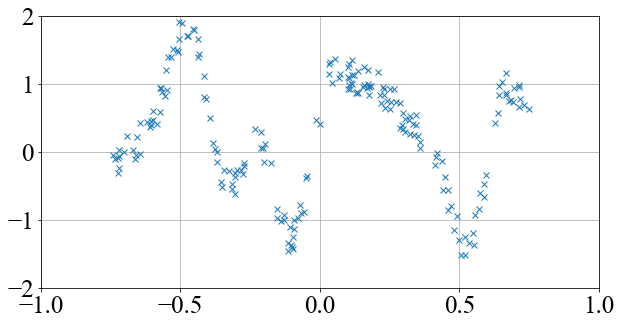

In [2]:
## Parameters 

xlim = (-1, 1)
ylim = (-2, 2)
n_train = 200
n_test = 200
σn = .5
logsn = np.log(σn)
lr = .01
num_steps = 20


## Data

def f_gen(x):
    return np.sin(x * 3 * 3.14) + \
           0.3 * np.cos(x * 9 * 3.14) + \
           0.5 * np.sin(x * 7 * 3.14)

## Plotting

npr.seed(0)
key = jax.random.PRNGKey(0)
X_train = np.expand_dims(npr.uniform(xlim[0]+.25, xlim[1]-.25, size=n_train), 1)
y_train = f_gen(X_train) + σn * npr.rand(n_train, 1)
data = (X_train, y_train)
X_test  = np.expand_dims(np.linspace(*xlim, n_test), 1)

X_train = device_put(X_train)
y_train = device_put(y_train)
X_test = device_put(X_test)

print(X_train.shape, y_train.shape)

fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(X_train, y_train, 'x', alpha=1)
ax.grid()
ax.set_ylim(ylim)
ax.set_xlim(xlim)

In [3]:
class SVGP(nn.Module, GPModel):
    n_data: int
    Xu_initial: np.ndarray

    def setup(self):
        self.d = self.Xu_initial.shape[1]
        self.n_inducing = self.Xu_initial.shape[0]

        self.k = CovSE()
        self.lik = LikNormal()
        def init_fn(k, s): return self.Xu_initial
        self.Xu = self.param('Xu', init_fn,
                             (self.n_inducing, self.d))
        self.q = VariationalMultivariateNormal(self.n_inducing)

    def get_init_params(self, key):
        Xs = np.ones((2, self.Xu_initial.shape[-1]))
        ys = np.ones((2, self.Xu_initial.shape[-1]))
        params = self.init(key, (Xs, ys), method=self.mll)
        return params

    def mll(self, data):
        X, y = data
        k = self.k
        Xu, μq, Lq = self.Xu, self.q.μ, self.q.L

        Kff = k(X, full_cov=False)
        Kuf = k(Xu, X)
        Kuu = k(Xu)
        Luu = cholesky_jitter(Kuu, jitter=5e-5)

        α = self.n_data/len(X) \
            if self.n_data is not None else 1.

        μqf, σ2qf = mvn_conditional_variational(Kff, Kuf,
                                                Luu, μq, Lq, full_cov=False)
        if isinstance(self.lik, LikMultipleNormal):
            elbo_lik = α*self.lik.variational_log_prob(y, μqf, σ2qf, X[:, -1])
        else:
            elbo_lik = α*self.lik.variational_log_prob(y, μqf, σ2qf)
        elbo_nkl = -kl_mvn_tril_zero_mean_prior(μq, Lq, Luu)
        elbo = elbo_lik + elbo_nkl

        return elbo, {'elbo_lik': elbo_lik, 
                      'elbo_nkl': elbo_nkl}

    def pred_f(self, Xs, full_cov=True):
        k = self.k
        Xu, μq, Lq = self.Xu, self.q.μ, self.q.L

        Kss = k(Xs, full_cov=full_cov)
        Kus = k(Xu, Xs)
        Kuu = k(Xu)
        Luu = cholesky_jitter(Kuu, jitter=5e-5)

        μf, Σf = mvn_conditional_variational(Kss, Kus,
                                             Luu, μq, Lq, full_cov=full_cov)
        return μf, Σf
    

n_inducing=5
key = jax.random.PRNGKey(0)
model = SVGP(n_data=n_train, Xu_initial=X_train[:n_inducing])
params = model.get_init_params(jax.random.PRNGKey(0))
bsz = 20
datas = (X_train[:bsz], y_train[:bsz])
model.apply(params, datas, method=model.mll)
params


NameError: name 'mvn_conditional_variational' is not defined

In [ ]:

bsz = 20
n_inducing = 50


fig, axs = plt.subplots(2, 2, figsize=(20,10), sharey=True)

def get_model(i):
    if i == 0:
        return 'GPR', GPR(data)
    if i == 1:
        return f'GPR+FITC (m={n_inducing})', GPRFITC(data, n_inducing)
    if i == 2:
        return f'GPR+VFE (m={n_inducing})', VFE(data, n_inducing)
    if i == 3:
        return f'SVGP (m={n_inducing})', SVGP(n_data=n_train, Xu_initial=data[0][:n_inducing])
    
    
def log_func(i, f, params):
    if i%20==0:
        print(f'[{i:3}]\tLoss={f(params):.3f}\t'
              f'lik.σn={jax.nn.softplus(params["params"]["lik"]["σ2"][0]):.3f}\t'
              f'k.ℓ={jax.nn.softplus(params["params"]["k"]["ℓ"][0]):.3f}\t'
              f'k.σ2={jax.nn.softplus(params["params"]["k"]["σ2"][0]):.3f}\t'
              + (f'Xu[:2]={params["params"]["Xu"][:2,0]}' if 'Xu' in params["params"] else ''))


n_batches, batches = get_data_stream(
    key, bsz, X_train, y_train)

for i in [0,1,2,3]:
    
    name, model = get_model(i)
    params = model.get_init_params(key)
    if i != 0:
        Xu_initial = params['params']['Xu']
    
    if i < 3:
        nmll = lambda params: -model.apply(params, method=model.mll)
        nmll = jax.jit(nmll)
        num_steps = 400
        params = pytree_mutate(params, {'params/k/ℓ': softplus_inv(np.array([0.5]))})
        params = flax_run_optim(nmll, params, num_steps=num_steps, log_func=log_func,
                                optimizer='GradientDescent', optimizer_kwargs={'learning_rate': .001})
        mll = model.apply(params, method=model.mll)
    else:
        ######################################################
        params = pytree_mutate(params, {'params/lik/σ2': softplus_inv(np.array([1.])),
                                        'params/k/ℓ': softplus_inv(np.array([0.5]))})

        @jax.jit
        def train_step(step, opt, batch):
            def f(params):
                fx, aux = model.apply(params, batch, method=model.mll)
                return -fx, aux
            fg_fn = jax.value_and_grad(f, has_aux=True)
            (fx, aux), grad = fg_fn(opt.target)
            opt = opt.apply_gradient(grad)
            log = {'step': step,
                   'loss': fx,
                   'lik.σ2': jax.nn.softplus(opt.target["params"]["lik"]["σ2"][0]),
                   'k.ℓ': jax.nn.softplus(opt.target["params"]["k"]["ℓ"][0]),
                   'k.σ2': jax.nn.softplus(opt.target["params"]["k"]["σ2"][0]),
                   'elbo_lik': aux['elbo_lik'],
                   'elbo_nkl': aux['elbo_nkl']}
            return opt, log
        
        num_steps = 1500
        opt = flax_create_optimizer(params, 'Adam', {'learning_rate': .002})
        for j in range(num_steps):
            for k in range(n_batches):
                step = j*n_batches+k
                batch = next(batches)
                opt, log = train_step(step, opt, batch)
                if step%(20*n_batches)==0:
                    print(f'[{log["step"]:3}]\t'
                          f'Loss={log["loss"]:.3f}\t'
                          f'lik.σ2={log["lik.σ2"]:.3f}\t'
                          f'k.ℓ={log["k.ℓ"]:.3f}\t'
                          f'k.σ2={log["k.σ2"]:.3f}\t'
                          f'L=lik+nkl={log["elbo_lik"]:.1f}+{log["elbo_nkl"]:.1f}')

        params = opt.target
        mll, aux = model.apply(params, data, method=model.mll)
        



    μ, σ2 = model.apply(params, X_test, full_cov=False, method=model.pred_y)
    std = np.sqrt(σ2).squeeze(); μ = μ.squeeze()

    ax = axs[i//2, i%2]
    ax.plot(X_test, μ, color='k')
    ax.fill_between(X_test.squeeze(), μ-2*std, μ+2*std, alpha=.2, color=cmap(0))
    ax.scatter(X_train, y_train, marker='x', color='r', s=50, alpha=.4)
    if i != 0:
        Xu = params['params']['Xu']
        ax.plot(Xu_initial, np.ones_like(Xu)*ylim[1]-.04, "k|", mew=2, label="Inducing locations")
        ax.plot(Xu, np.ones_like(Xu)*ylim[0]+.04, "k|", mew=2, label="Inducing locations")
    ax.grid()
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title(f'{name}: {"mll" if i <3 else "elbo"}={-mll:.2f}')
    

fig.tight_layout()
plt_savefig(fig, 'summary/assets/plt_apx_comparison.png')
    

In [ ]:
μ.shape